In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

## Initial setup

First we fetch the data from ucirepo, and then do some basic analysis of the data.

In [3]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [4]:
print(data.head())

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

In [5]:
#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

Drug 106
Age 0
Sex 0
Ascites 106
Hepatomegaly 106
Spiders 106
Edema 0
Bilirubin 0
Cholesterol 134
Albumin 0
Copper 108
Alk_Phos 106
SGOT 106
Tryglicerides 136
Platelets 11
Prothrombin 2
Stage 6


We realized there are some variables where the values are saved as strings and some of them had the value "NaNN", indicating a missing value, but not being detected as a nan. Here we count the number of missing values per variable.

In [6]:
print(data.describe())

                Age   Bilirubin     Albumin      Alk_Phos        SGOT  \
count    418.000000  418.000000  418.000000    312.000000  312.000000   
mean   18533.351675    3.220813    3.497440   1982.655769  122.556346   
std     3815.845055    4.407506    0.424972   2140.388824   56.699525   
min     9598.000000    0.300000    1.960000    289.000000   26.350000   
25%    15644.500000    0.800000    3.242500    871.500000   80.600000   
50%    18628.000000    1.400000    3.530000   1259.000000  114.700000   
75%    21272.500000    3.400000    3.770000   1980.000000  151.900000   
max    28650.000000   28.000000    4.640000  13862.400000  457.250000   

       Prothrombin       Stage  
count   416.000000  412.000000  
mean     10.731731    3.024272  
std       1.022000    0.882042  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.600000    3.000000  
75%      11.100000    4.000000  
max      18.000000    4.000000  


# PCA

Now we'll analyze PCA and plot different things. First, we will drop the binary/text variables and drop all the touples containing missing values.

In [7]:
data.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)

data = data.dropna()

data.describe()

,Age,Bilirubin,Albumin,Alk_Phos,SGOT,Prothrombin,Stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,18189.326087,3.333696,3.516812,1996.611594,124.119239,10.735507,3.039855
std,3843.555619,4.601074,0.404789,2115.477894,56.719952,1.008315,0.853999
min,9598.000000,0.300000,1.960000,289.000000,28.380000,9.000000,1.000000
25%,15162.500000,0.800000,3.310000,922.500000,82.457500,10.000000,2.000000
50%,18156.500000,1.400000,3.545000,1277.500000,116.625000,10.600000,3.000000
75%,20667.500000,3.525000,3.772500,2068.250000,153.450000,11.200000,4.000000
max,28650.000000,28.000000,4.400000,13862.400000,457.250000,17.100000,4.000000


Now, converting all strings to int

In [8]:
#convert all data to integers

ints = ['Age', 'Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']

for i in ints:
    print(i)
    data[i] = list(map(int, data[i]))

Age
Copper
Platelets
Cholesterol
Tryglicerides


No we will fill a matrix with the values for easo of use for the PCA, plotting and transformations.

In [9]:
print(len(data))

276


In [10]:
# Extract attribute names (1st row, column 4 to 12)
attributeNames = list(data.columns)

# Extract class names to python list
classLabels = sorted(set(data.Stage))
y = data.Stage

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(1,11)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classLabels)

print(N, M, C)

276 11 4


In [11]:
convert = ['Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Bilirubin']

# Convert the columns to log scale
# for col in convert:
#     data[col] = np.log(data[col])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(0,10)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

scaler = StandardScaler()
Y_scaled = scaler.fit_transform(X)

# Subtract mean value from data
Y_scaled = Y_scaled - np.ones((N, 1)) * Y_scaled.mean(0)

Outter fold: 1/10


100%|██████████| 100/100 [00:00<00:00, 1553.34it/s]


Outter fold: 2/10


100%|██████████| 100/100 [00:00<00:00, 1703.19it/s]


Outter fold: 3/10


100%|██████████| 100/100 [00:00<00:00, 1717.35it/s]


Outter fold: 4/10


100%|██████████| 100/100 [00:00<00:00, 1735.88it/s]


Outter fold: 5/10


100%|██████████| 100/100 [00:00<00:00, 1245.73it/s]


Outter fold: 6/10


100%|██████████| 100/100 [00:00<00:00, 1967.62it/s]


Outter fold: 7/10


100%|██████████| 100/100 [00:00<00:00, 1780.46it/s]


Outter fold: 8/10


100%|██████████| 100/100 [00:00<00:00, 1754.30it/s]


Outter fold: 9/10


100%|██████████| 100/100 [00:00<00:00, 2322.94it/s]


Outter fold: 10/10


100%|██████████| 100/100 [00:00<00:00, 1719.52it/s]


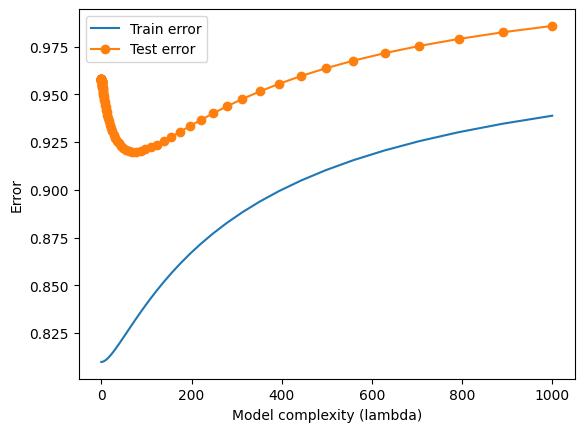

In [29]:
# exercise 6.1.1

import importlib_resources
import numpy as np
from matplotlib.pylab import figure, legend, plot, show, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection, tree

from sklearn import model_selection
import numpy as np
import sklearn.linear_model

from tqdm import tqdm

# Tree complexity parameter - constraint on maximum depth
lambdas = np.logspace(-2, 3, num = 100)

X = Y_scaled[:,1:]
y = Y_scaled[:,0]

# Simple holdout-set crossvalidation
test_proportion = 0.5
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=test_proportion
)

K1 = 10
k1 = 0

Err_train = np.empty((K1, len(lambdas)))
Err_test = np.empty((K1, len(lambdas)))

for par_index, test_index in model_selection.KFold(K1).split(X):
    print("Outter fold: {0}/{1}".format(k1 + 1, K1))

    train_err = []
    test_err = []

    for l in tqdm(lambdas):
        
        linear_model = sklearn.linear_model.Ridge(alpha=l).fit(X_train, y_train)

        y_est_train = np.asarray(linear_model.predict(X_train), dtype=int)
        
        lr_trainerr = np.mean((linear_model.predict(X_train) - y_train) ** 2)
        lr_testerr = np.mean((linear_model.predict(X_test) - y_test) ** 2)

        train_err.append(lr_trainerr)
        test_err.append(lr_testerr)
    
    Err_train[k1, :] = train_err
    Err_test[k1, :] = test_err

    k1 += 1

train_err = np.mean(Err_train, axis=0)
test_err = np.mean(Err_test, axis=0)

f = figure()
plot(lambdas, train_err)
plot(lambdas, test_err, marker="o")
xlabel("Model complexity (lambda)")
ylabel("Error")
legend(["Train error", "Test error"])

show()


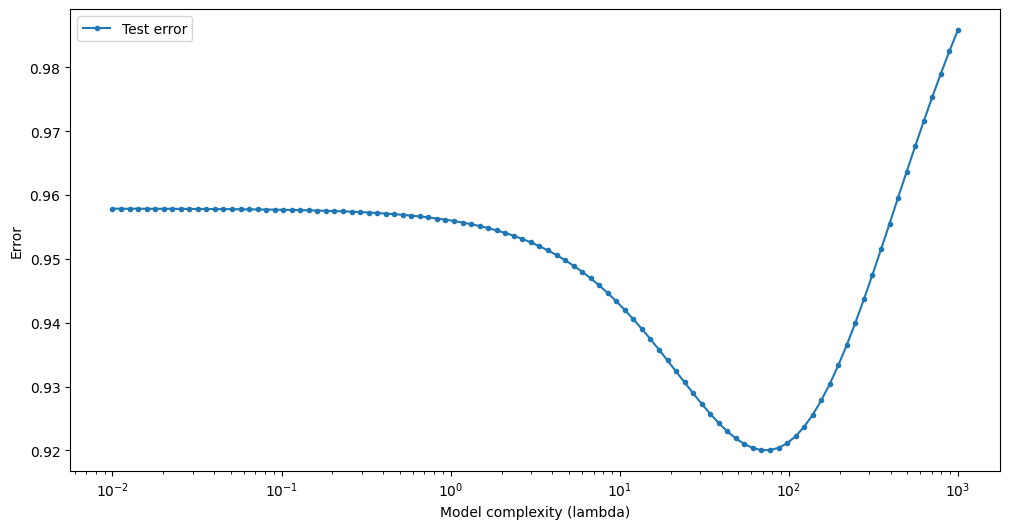

In [30]:
f = figure(figsize=(12, 6))
plot(lambdas, test_err, marker=".")
# logarithmic scale
plt.xscale("log")
xlabel("Model complexity (lambda)")
ylabel("Error")
legend(["Test error"])